# Webtoon Comments Scraping ! - Best Comments

### Scraping

In [9]:
# import field

import re
import copy
import time
import sqlite3
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import random
from selenium.webdriver.common.alert import Alert
from selenium.webdriver.chrome.options import Options

In [10]:
### 전 회차 url 따기
# 웹툰의 title
def get_all_episode_url(title_id):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    episode_urls = []
    for i in range(1, 1000):
        now_episode_urls = copy.deepcopy(episode_urls)
        url = f"https://comic.naver.com/webtoon/list?titleId={title_id}&page={i}&sort=ASC"
        driver.get(url)
        time.sleep(0.5)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        episode_divs = soup.find_all('li', {'class': 'EpisodeListList__item--M8zq4'})
        for episode_div in episode_divs:
            a_tag = episode_div.find('a')
            href = 'https://comic.naver.com' + a_tag['href']
            episode_urls.append(href)
        episode_urls = sorted(list(set(episode_urls)))
        if now_episode_urls == episode_urls:
            break
    driver.quit()
    return episode_urls

In [11]:
def handle_alert(driver):
    try:
        alert = Alert(driver)
        alert_text = alert.text
        print(f'경고창 닫힘: {alert_text}')
        alert.accept()
    except:
        pass

def put_best_comment_to_db(title_id, episode_url):
    # Chrome 드라이버 설정
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # 백그라운드에서 실행
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    
    # 웹페이지 열기
    driver.get(episode_url)
    time.sleep(0.5)

    # /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul 안에 있는 댓글li태그 찾기
    comment_list_element = driver.find_element(By.XPATH, '/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul')

    # 모든 li 태그 찾기
    li_elements = comment_list_element.find_elements(By.TAG_NAME, 'li')

    # li 요소들의 텍스트를 리스트로 저장
    li_texts = []
    for li in li_elements:
        try:
            li_texts.append(li.get_attribute('innerHTML'))
        except Exception as e:
            print('li 텍스트를 가져오는 중 에러 발생:', e)
            handle_alert(driver)  # 경고창 처리

    # 해당 정보를 DB에 삽입
    conn = sqlite3.connect('webtoon_best_comments.db')
    cursor = conn.cursor()
    for li_text in li_texts:
        cursor.execute('''
            INSERT INTO comments (TitleID, URL, CommentLi) VALUES (?, ?, ?)
        ''', (title_id, episode_url, li_text))
        
    conn.commit()
    conn.close()

    # 드라이버 종료
    driver.quit()

In [12]:
### 웹툰 -> "격기 3반" 
kk3b_id = '701535'
kk3b_urls = get_all_episode_url(kk3b_id)

for episode_url in kk3b_urls:
    put_best_comment_to_db(kk3b_id, episode_url)

### Word Cloud

In [2]:
# import field
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re


In [3]:
### 데이터 불러오기 
conn = sqlite3.connect('webtoon_best_comments.db')

cursor = conn.cursor()

query = """
SELECT * FROM Comments
"""

df = pd.read_sql_query(query, conn)

conn.close()

In [4]:
df.head()

,TitleID,URL,CommentLi
0,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_..."
1,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_..."
2,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_..."
3,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_..."
4,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_..."


In [5]:
### df에 comment만 있는 컬럼 추가
def extract_comment_content(html):
    soup = BeautifulSoup(html, 'html.parser')
    content = soup.find('span', class_='u_cbox_contents')
    return content.text.strip() if content else None

df['CommentContent'] = df['CommentLi'].apply(extract_comment_content)

In [6]:
df.head()

,TitleID,URL,CommentLi,CommentContent
0,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",어디서 대작나무 타는 냄새가?
1,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",오!! 내가 좋아하는 주인공 설정이다!!실제로 개쎈데 약한척하는거 ㅋㅋㅋ\n작가님 ...
2,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",뭔데 별점이리낮음? 신입작가분 아무짓도 안했는데 인제 시작인데 ㅋㅋㅋㅋㅋ
3,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",격기3반은 잡지 챔프에서 연재하고 단행본도나온 만화입니다.. 다른 연애격투웹툰이랑ㅇ...
4,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",저딴게 왜 베뎃이냐 신입한테 성모 언급 하지 마라 제발


In [15]:
### 특수문자 제거 + 토크나이즈 => 통스트링으로 새로운 컬럼

okt = Okt()
stopwords = set(['그리고', '하는', '에서', '다', '안', '로', '하고', '을', '도', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '를', '으로', '자', '에', '와', '한', '하다'])

def ko_text_process(text):
    if text == None:
        return ' '
    cleaned_text = re.sub(r'[^가-힣\s]', ' ', text).replace('\n', ' ')    
    tokens = okt.morphs(cleaned_text)
    cleaned_tokens = [word for word in tokens if word not in stopwords]

    return ' '.join(cleaned_tokens)

df['TokenizedComment'] = df['CommentContent'].apply(ko_text_process)

In [16]:
df.head()

,TitleID,URL,CommentLi,CommentContent,TokenizedComment
0,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",어디서 대작나무 타는 냄새가?,어디서 대작 나무 타는 냄새
1,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",오!! 내가 좋아하는 주인공 설정이다!!실제로 개쎈데 약한척하는거 ㅋㅋㅋ\n작가님 ...,오 내 좋아하는 주인공 설정 이다 실제 개 쎈데 약 척 하는거 작가 님 아직 화인 ...
2,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",뭔데 별점이리낮음? 신입작가분 아무짓도 안했는데 인제 시작인데 ㅋㅋㅋㅋㅋ,뭔 데 별 점 이리 낮음 신입 작가 분 아무 짓 했는데 인제 시작 인데
3,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",격기3반은 잡지 챔프에서 연재하고 단행본도나온 만화입니다.. 다른 연애격투웹툰이랑ㅇ...,격기 반 잡지 챔프 연재 단행본 나온 만화 입니다 다른 연애 격투 웹툰 이랑 다른 ...
4,701535,https://comic.naver.com/webtoon/detail?titleId...,"<div class=""u_cbox_comment_box""><div class=""u_...",저딴게 왜 베뎃이냐 신입한테 성모 언급 하지 마라 제발,저딴 게 왜 베뎃 이냐 신입 한테 성모 언급 하지 마라 제발


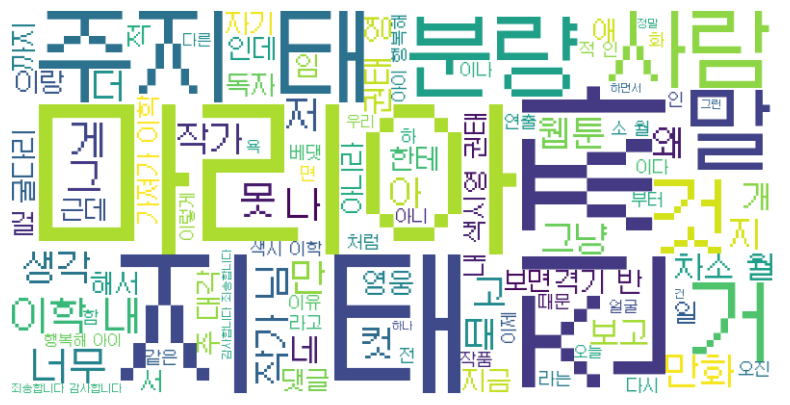

In [17]:
text_for_wordcloud = ' '.join(df['TokenizedComment'])
wordcloud = WordCloud(font_path='../fonts/Galmuri11.ttf', max_words = 100, width=800, height=400, background_color='white').generate(text_for_wordcloud)

# 워드 클라우드 !
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# 해당 웹툰은 가면 갈수록 분량이 말도 안되게 박살납니다.(그것때문에 말이 많긴 한가봐요)
# 주인공 이름과 서브 주인공 이름이 많이 등장하네요.
# 각 에피소드 별로 비중 있고 심도 있게 다루는 단어들이 많이 등장합니다